In [ ]:
# import the necessary packages.
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
#!pip install torchsummary
from torchsummary import summary

In [ ]:
# Load CUDa
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
# importing the model from the model.py
from model import Net

In [ ]:
# Calling the model
model = Net().to(device)
# displaying the model summary.
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
       BatchNorm2d-2            [-1, 8, 26, 26]              16
            Conv2d-3           [-1, 16, 24, 24]           1,168
            Conv2d-4           [-1, 32, 10, 10]           4,640
           Dropout-5           [-1, 32, 10, 10]               0
       BatchNorm2d-6           [-1, 32, 10, 10]              64
            Linear-7                   [-1, 10]          32,010
Total params: 37,978
Trainable params: 37,978
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.23
Params size (MB): 0.14
Estimated Total Size (MB): 0.37
----------------------------------------------------------------


In [48]:
# Train data transformations
# List of transformations applied are
# CenterCrop, Resize of the images to (28,28)
# Rotation of the image and Normalizing the image
torch.manual_seed(1)
batch_size = 512

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
# Test data transformations
# List of transformations applied are
# Normalizing the image with same parameter as Train data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [49]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [50]:
# Training the model of the train dataset.
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

# Testing the trained model on test dataset to the check loss and model accuracy
def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))


In [52]:
# performance optimization of the model.
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# New Line
criterion = F.nll_loss
num_epochs = 10

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer,criterion)
  test(model, device, test_loader,criterion)


Epoch 1


Train: Loss=0.0955 Batch_id=117 Accuracy=92.85: 100%|██████████| 118/118 [00:52<00:00,  2.25it/s]


Test set: Average loss: 0.0615, Accuracy: 9810/10000 (98.10%)

Epoch 2


Train: Loss=0.0687 Batch_id=117 Accuracy=98.28: 100%|██████████| 118/118 [00:52<00:00,  2.26it/s]


Test set: Average loss: 0.0471, Accuracy: 9838/10000 (98.38%)

Epoch 3


Train: Loss=0.0895 Batch_id=117 Accuracy=98.76: 100%|██████████| 118/118 [00:52<00:00,  2.26it/s]


Test set: Average loss: 0.0446, Accuracy: 9857/10000 (98.57%)

Epoch 4


Train: Loss=0.0080 Batch_id=117 Accuracy=98.97: 100%|██████████| 118/118 [00:51<00:00,  2.29it/s]


Test set: Average loss: 0.0367, Accuracy: 9877/10000 (98.77%)

Epoch 5


Train: Loss=0.0414 Batch_id=117 Accuracy=99.15: 100%|██████████| 118/118 [00:51<00:00,  2.30it/s]


Test set: Average loss: 0.0335, Accuracy: 9883/10000 (98.83%)

Epoch 6


Train: Loss=0.0168 Batch_id=117 Accuracy=99.36: 100%|██████████| 118/118 [00:51<00:00,  2.30it/s]


Test set: Average loss: 0.0336, Accuracy: 9893/10000 (98.93%)

Epoch 7


Train: Loss=0.0472 Batch_id=117 Accuracy=99.45: 100%|██████████| 118/118 [00:51<00:00,  2.31it/s]


Test set: Average loss: 0.0327, Accuracy: 9891/10000 (98.91%)

Epoch 8


Train: Loss=0.0109 Batch_id=117 Accuracy=99.53: 100%|██████████| 118/118 [00:50<00:00,  2.32it/s]


Test set: Average loss: 0.0313, Accuracy: 9894/10000 (98.94%)

Epoch 9


Train: Loss=0.0066 Batch_id=117 Accuracy=99.61: 100%|██████████| 118/118 [00:51<00:00,  2.30it/s]


Test set: Average loss: 0.0292, Accuracy: 9899/10000 (98.99%)

Epoch 10


Train: Loss=0.0046 Batch_id=117 Accuracy=99.67: 100%|██████████| 118/118 [00:50<00:00,  2.31it/s]


Test set: Average loss: 0.0286, Accuracy: 9907/10000 (99.07%)



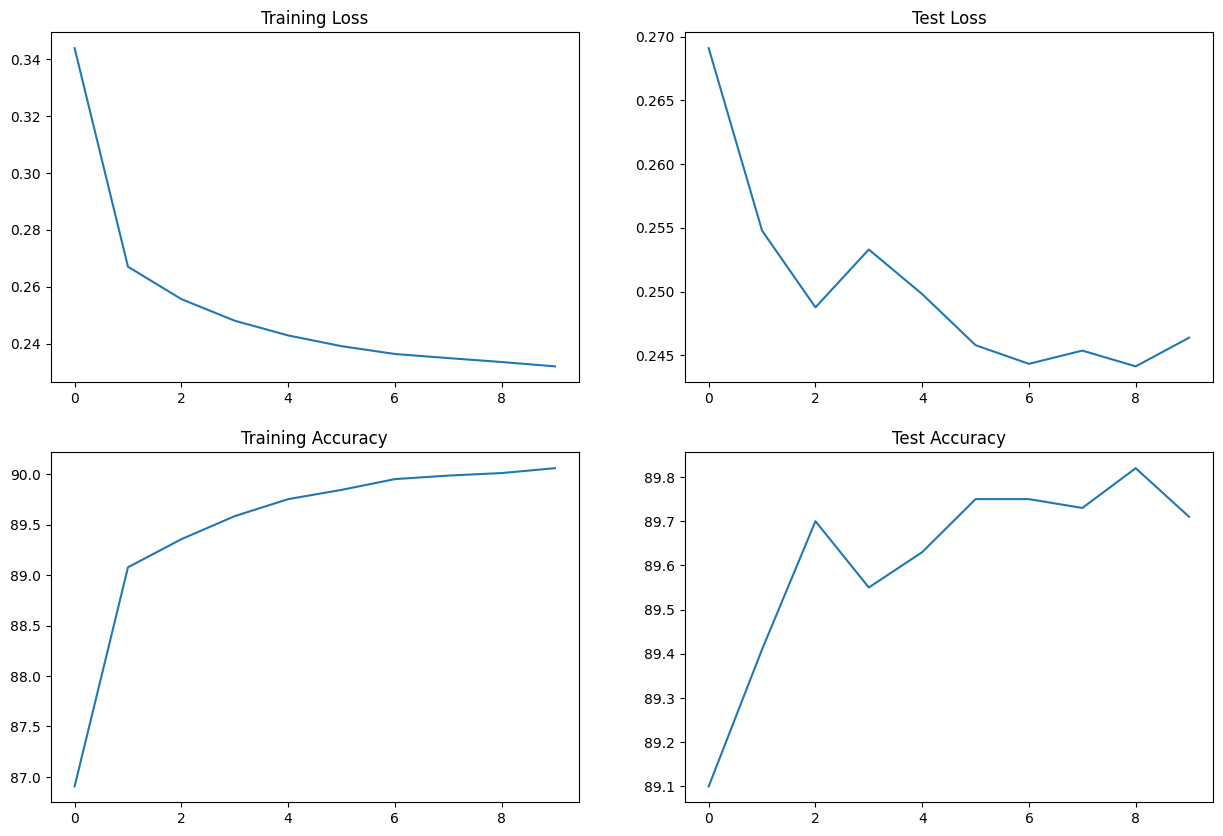

In [43]:
from utils import display_plot

display_plot(train_losses,train_acc,test_losses,test_acc)